In [1]:
import numpy as np 
import pandas as pd 

import os
import keras
import tensorflow as tf
from keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from IPython.display import Image, display

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
data = pd.read_csv('../input/digit-recognizer/train.csv')
X = data.drop('label', axis=1).values
y2 = data['label'].values

X = np.array(X)
y2 = np.array(y2)
X_train, X_test, y_train2, y_test2 = train_test_split(X, y2, test_size=0.1, random_state=42)

# Rescaling and reshaping the images
x_train = X_train.astype('float32') / 255.
x_train = x_train.reshape(-1, 28, 28, 1)
y_train = np.array(to_categorical(y_train2.astype('float32')))

x_test = X_test.astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1)
y_test = np.array(to_categorical(y_test2.astype('float32')))

In [3]:
# Squashing function
def squash(vectors, axis=-1):
    squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = squared_norm / (1 + squared_norm) / (K.sqrt(squared_norm) + K.epsilon())
    return scale * vectors

In [4]:
# Creating a custom capsule layer
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsule, dim_capsule, routing=3, kernel_initializer='glorot_uniform', **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routing = routing
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule, self.dim_capsule, self.input_dim_capsule], initializer=self.kernel_initializer, name='w')
        self.built = True

    def call(self, inputs, training=None):
        input_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)
        inputs_tiled = K.tile(input_expand, [1, self.num_capsule, 1, 1, 1])
        input_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))
        b = tf.zeros(shape=[tf.shape(inputs)[0], self.num_capsule, 1, self.input_num_capsule])
        for i in range(self.routing):
            c = tf.nn.softmax(b, axis=1)
            output = squash(tf.matmul(c, input_hat))
            if i < self.routing - 1:
                b += tf.matmul(output, input_hat, transpose_b=True)
        return tf.squeeze(output)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routing
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# Create a custom masking layer
class Mask(layers.Layer):
    def call(self, inputs, **kwargs):
        if type(inputs) is list:
            inputs, mask = inputs
        else:
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            mask = tf.one_hot(indices=tf.argmax(x, 1), depth=x.shape[1])
        masked = K.batch_flatten(inputs * tf.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        return super(Mask, self).get_config()
    

# Create a custom length layer
class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        return super(Length, self).get_config()

# Define the custom margin loss function
def margin_loss(y_true, y_pred):
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, 1))

In [5]:
# Setting the image shape
img_shape = (28, 28, 1)
inp = layers.Input(img_shape, 100, name="InputLayer")


# 2. Capsule Network architecture

# Primary Capsule layer
conv1 = layers.Conv2D(filters=256, kernel_size=(9, 9), activation='relu', padding='valid', name="Conv1")(inp)
bn1 = layers.BatchNormalization(name="BN1")(conv1)
maxpool1 = layers.MaxPooling2D(pool_size=(1, 1), name="MaxPool1")(bn1)
conv2 = layers.Conv2D(filters=128, kernel_size=(9, 9), activation='relu', padding='valid', name="Conv2")(maxpool1)
bn2 = layers.BatchNormalization(name="BN2")(conv2)
conv3 = layers.Conv2D(filters=8 * 16, kernel_size=(9, 9), strides=2, padding='valid', activation=None, name="Conv3")(bn2)
reshape = layers.Reshape([-1, 8], name="Reshape")(conv3)
squashed_output = layers.Lambda(squash, name="Squash")(reshape)

# Digital Capsule layer
digitcaps = CapsuleLayer(num_capsule=10, dim_capsule=16, routing=3, name='digitcaps')(squashed_output)
out_caps = Length(name='capsnet')(digitcaps)

# Masking 
y = layers.Input(shape=(10,), name="InputLabel")
masked_by_y = Mask(name="MaskedByY")([digitcaps, y])
masked = Mask(name="Masked")(digitcaps)

# 3. Decoder (Reconstruction) layer
decoder = models.Sequential(name='decoder')
decoder.add(layers.Dense(512, activation='relu', input_dim=16 * 10, name="DecoderDense1"))
decoder.add(layers.Dropout(0.5, name="DecoderDropout1"))
decoder.add(layers.Dense(1024, activation='relu', name="DecoderDense2"))
decoder.add(layers.Dropout(0.5, name="DecoderDropout2"))
decoder.add(layers.Dense(np.prod(img_shape), activation='sigmoid', name="DecoderDense3"))
decoder.add(layers.Reshape(target_shape=img_shape, name='out_recon'))

# 4. Final Model
train_model = models.Model(inputs=[inp, y], outputs=[out_caps, decoder(masked_by_y)], name="TrainModel")
eval_model = models.Model(inputs=inp, outputs=[out_caps, decoder(masked)], name="EvalModel")

Model: "TrainModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(100, 28, 28, 1)]   0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (100, 20, 20, 256)   20992       ['InputLayer[0][0]']             
                                                                                                  
 BN1 (BatchNormalization)       (100, 20, 20, 256)   1024        ['Conv1[0][0]']                  
                                                                                                  
 MaxPool1 (MaxPooling2D)        (100, 20, 20, 256)   0           ['BN1[0][0]']                    
                                                                                         

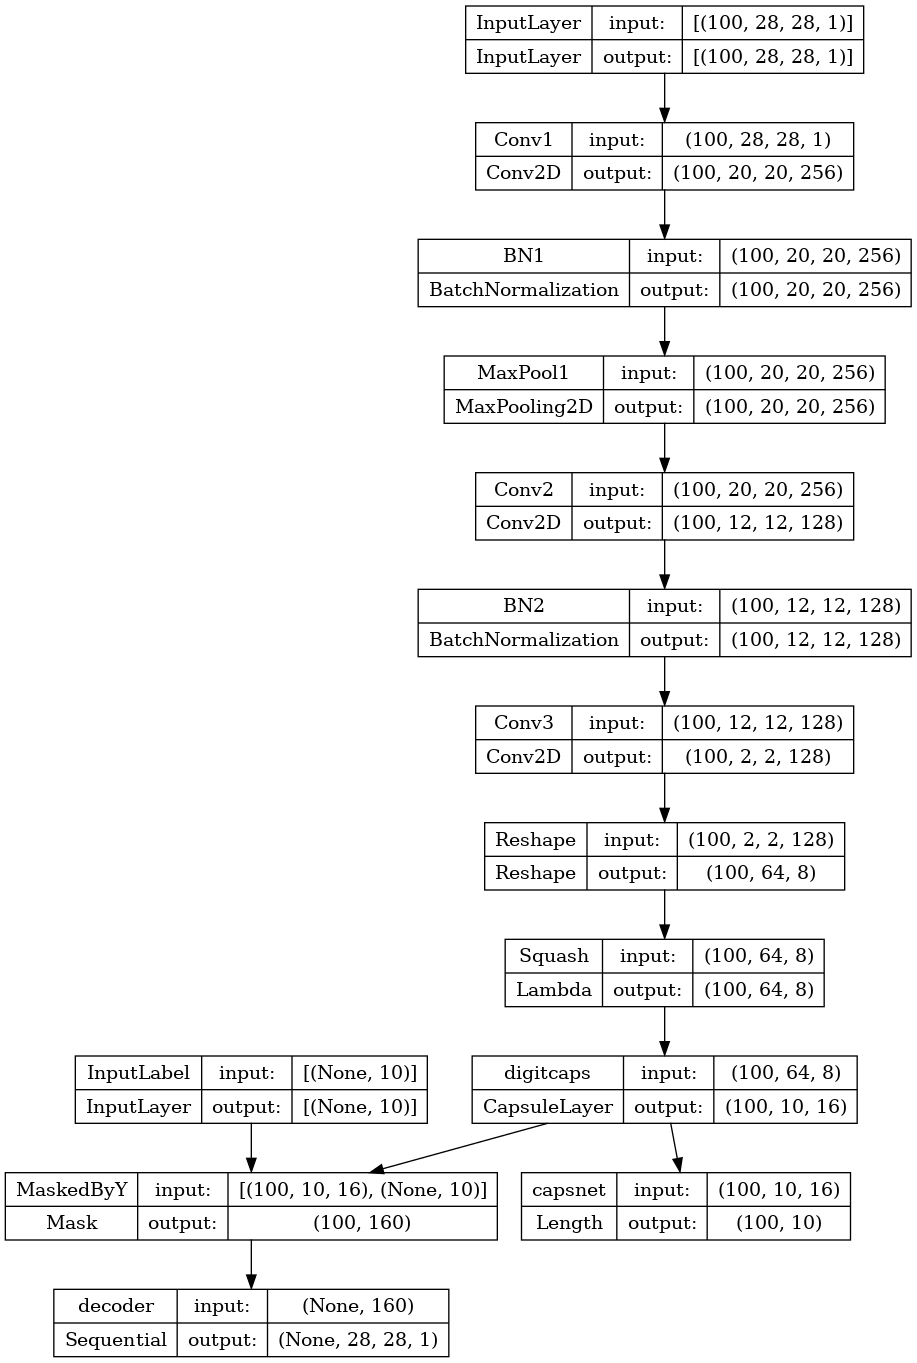

In [6]:
# Print model summary
train_model.summary()
# Create a plot of the model architecture
plot = plot_model(train_model, show_shapes=True, show_layer_names=True, to_file='temp_model_plot.png')

# Display the image in Jupyter Notebook
display(Image(filename='temp_model_plot.png'))

In [7]:
# Pre-process the data and perform train-test split
X = X.astype('float32') / 255.
X = X.reshape(-1, 28, 28, 1)
y = to_categorical(y2.astype('float32'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        fill_mode = 'nearest',
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1
        )

datagen.fit(x_train)

x_augmented = []
y_augmented = []

# Define how many augmented images you want per original image
augment_factor = 3
batches = 0
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=x_train.shape[0]):
    x_augmented.append(x_batch)
    y_augmented.append(y_batch)
    batches += 1
    if batches >= augment_factor:
        break

# Convert lists to numpy arrays
x_augmented = np.concatenate(x_augmented)
y_augmented = np.concatenate(y_augmented)

In [9]:
x_train = np.concatenate((x_train, x_augmented))
y_train = np.concatenate((y_train, y_augmented))

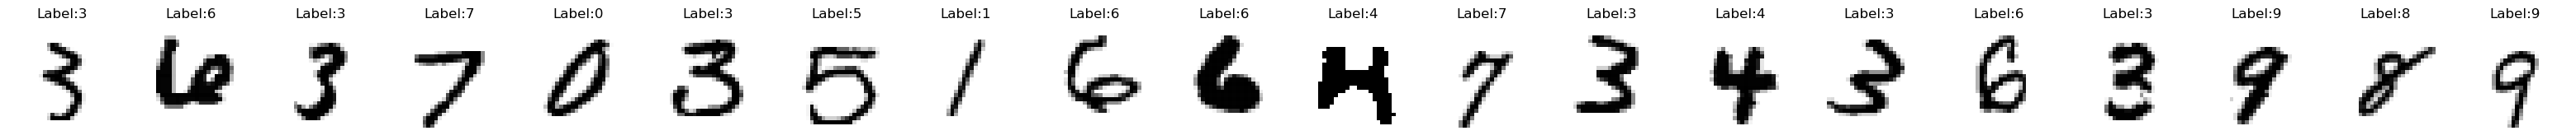

In [10]:
# Display random sample data
n_samples = 20

# Generate random indices
random_indices = np.random.choice(4000, n_samples, replace=False)
plt.figure(figsize=(n_samples * 2, 3))
for i, random_index in enumerate(random_indices):
    plt.subplot(1, n_samples, i + 1)
    sample_image = X_test[random_index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.title("Label:" + str(np.argmax(y_test[random_index])))
    plt.axis("off")
plt.show()

In [11]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_capsnet_accuracy', mode='max', patience=4, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_capsnet_accuracy', mode='max', factor=0.5, patience=3)

train_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                    loss=[margin_loss, 'mse'], 
                    loss_weights=[1., 0.0005], 
                    metrics=['accuracy'])
 
train_model.fit([x_train, y_train], 
                [y_train, x_train], 
                batch_size=200, 
                epochs=20, 
                validation_data=([x_test, y_test], [y_test, x_test]),
                callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
756/756 [==============================] - 148s 184ms/step - loss: 0.0333 - capsnet_loss: 0.0333 - decoder_loss: 0.1073 - capsnet_accuracy: 0.9701 - decoder_accuracy: 0.7099 - val_loss: 0.0080 - val_capsnet_loss: 0.0080 - val_decoder_loss: 0.0673 - val_capsnet_accuracy: 0.9912 - val_decoder_accuracy: 0.8082 - lr: 0.0010
Epoch 2/20
756/756 [==============================] - 138s 182ms/step - loss: 0.0059 - capsnet_loss: 0.0059 - decoder_loss: 0.0646 - capsnet_accuracy: 0.9935 - decoder_accuracy: 0.7544 - val_loss: 0.0067 - val_capsnet_loss: 0.0067 - val_decoder_loss: 0.0647 - val_capsnet_accuracy: 0.9924 - val_decoder_accuracy: 0.8081 - lr: 0.0010
Epoch 3/20
756/756 [==============================] - 137s 181ms/step - loss: 0.0037 - capsnet_loss: 0.0037 - decoder_loss: 0.0621 - capsnet_accuracy: 0.9959 - decoder_accuracy: 0.7548 - val_loss: 0.0103 - val_capsnet_loss: 0.0103 - val_decoder_loss: 0.0604 - val_capsnet_accuracy: 0.9890 - val_decoder_accuracy: 0.8052 - lr: 0.0010
E

125/125 [==============================] - 2s 14ms/step


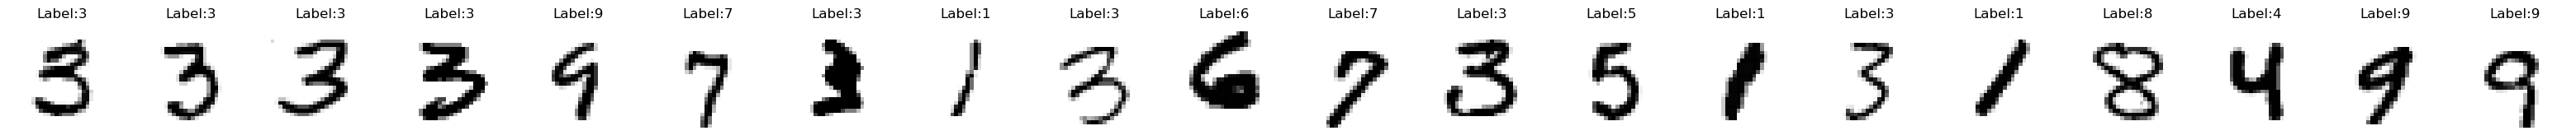

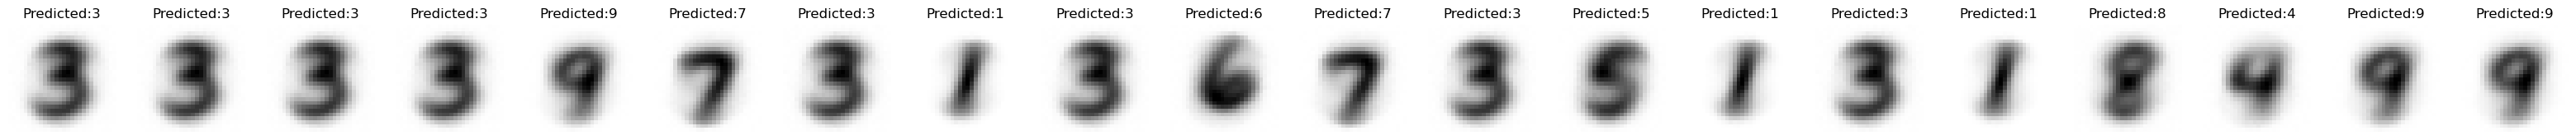

In [12]:
# Make predictions on a subset of the test data
label_predicted, image_predicted = train_model.predict([X_test[:4000], y_test[:4000]])

# Generate random indices for the first 4000 samples
random_indices = np.random.choice(4000, n_samples, replace=False)
plt.figure(figsize=(n_samples * 2, 3))
for i, random_index in enumerate(random_indices):
    plt.subplot(1, n_samples, i + 1)
    sample_image = X_test[random_index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.title("Label:" + str(np.argmax(y_test[random_index])))
    plt.axis("off")
plt.show()

# Visualize predicted (reconstructed) test images
plt.figure(figsize=(n_samples * 2, 3))
for i, random_index in enumerate(random_indices):
    plt.subplot(1, n_samples, i + 1)
    sample_image = image_predicted[random_index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.title("Predicted:" + str(np.argmax(label_predicted[random_index])))
    plt.axis("off")
plt.show()

125/125 [==============================] - 2s 14ms/step


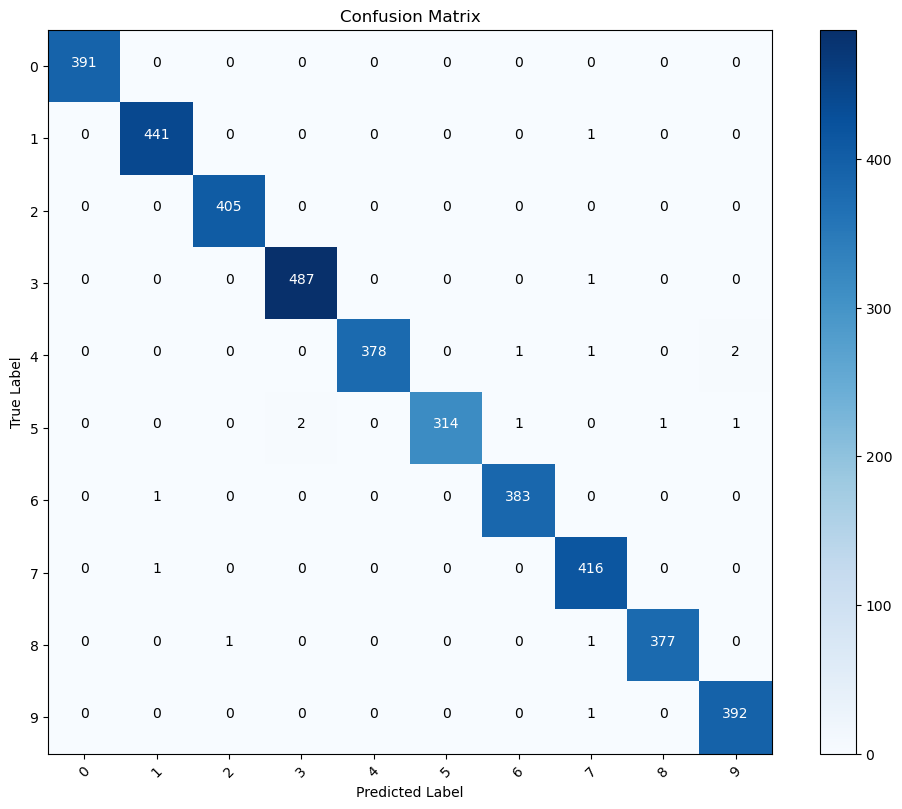

In [13]:
label_predicted, _ = train_model.predict([X_test[:4000], y_test[:4000]])
predicted_classes = np.argmax(label_predicted, axis=1)
true_classes = np.argmax(y_test[:4000], axis=1)
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(np.unique(true_classes)))
plt.xticks(tick_marks, np.unique(true_classes), rotation=45)
plt.yticks(tick_marks, np.unique(true_classes))

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

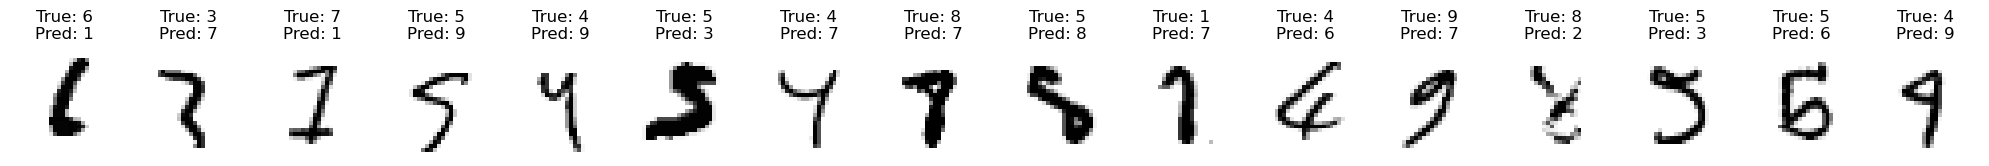

In [14]:
# Get the indices where the predictions and true labels mismatch
mismatched_indices = np.where(predicted_classes != true_classes)[0]

# If there are too many mismatched images, select a subset
n_mismatched_samples = len(mismatched_indices)
n_display = min(n_mismatched_samples, 20) # Display at most 20 images

selected_mismatched_indices = np.random.choice(mismatched_indices, n_display, replace=False)

# Display the images
fig, axes = plt.subplots(1, n_display, figsize=(20, 4))
for ax, mismatched_index in zip(axes, selected_mismatched_indices):
    sample_image = X_test[mismatched_index].reshape(28, 28)
    ax.imshow(sample_image, cmap="binary")
    ax.set_title(f"True: {true_classes[mismatched_index]}\nPred: {predicted_classes[mismatched_index]}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()

125/125 [==============================] - 2s 13ms/step


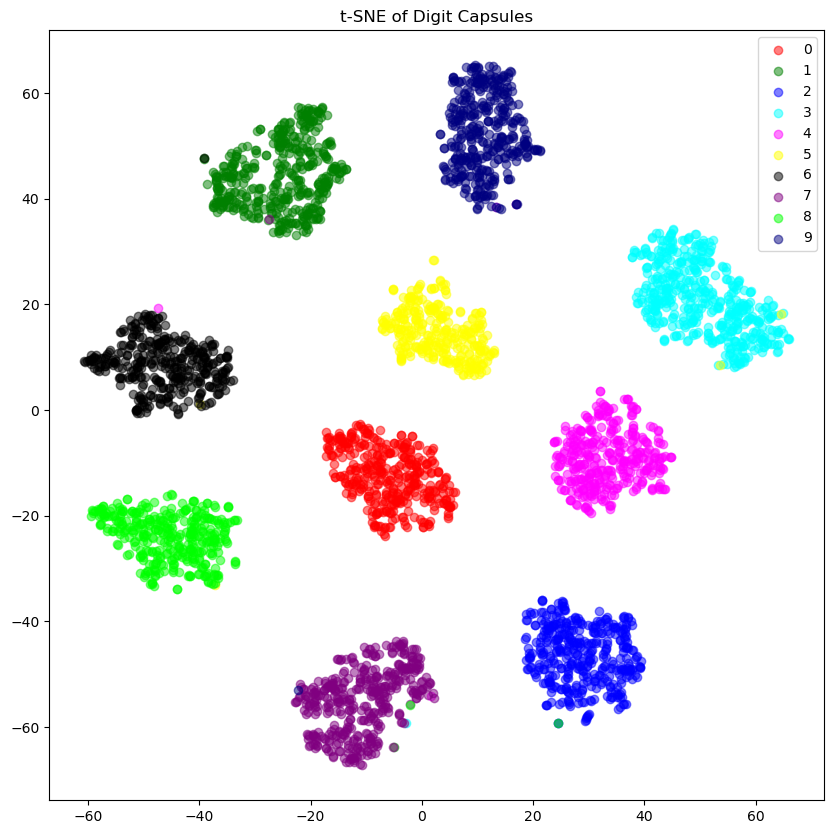

In [15]:
# Model to get the digit capsules
capsule_model = models.Model(inputs=inp, outputs=digitcaps)

digit_capsules = capsule_model.predict(x_test[:4000])
digit_capsules_reshaped = digit_capsules.reshape((-1, digit_capsules.shape[1]*digit_capsules.shape[2]))

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(digit_capsules_reshaped)

plt.figure(figsize=(10, 10))

for i, c in zip(range(10), ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'lime', 'navy']):
    plt.scatter(tsne_results[y_test2[:4000] == i, 0], tsne_results[y_test2[:4000] == i, 1], c=c, label=i, alpha=0.5)

plt.legend()
plt.title('t-SNE of Digit Capsules')
plt.show()

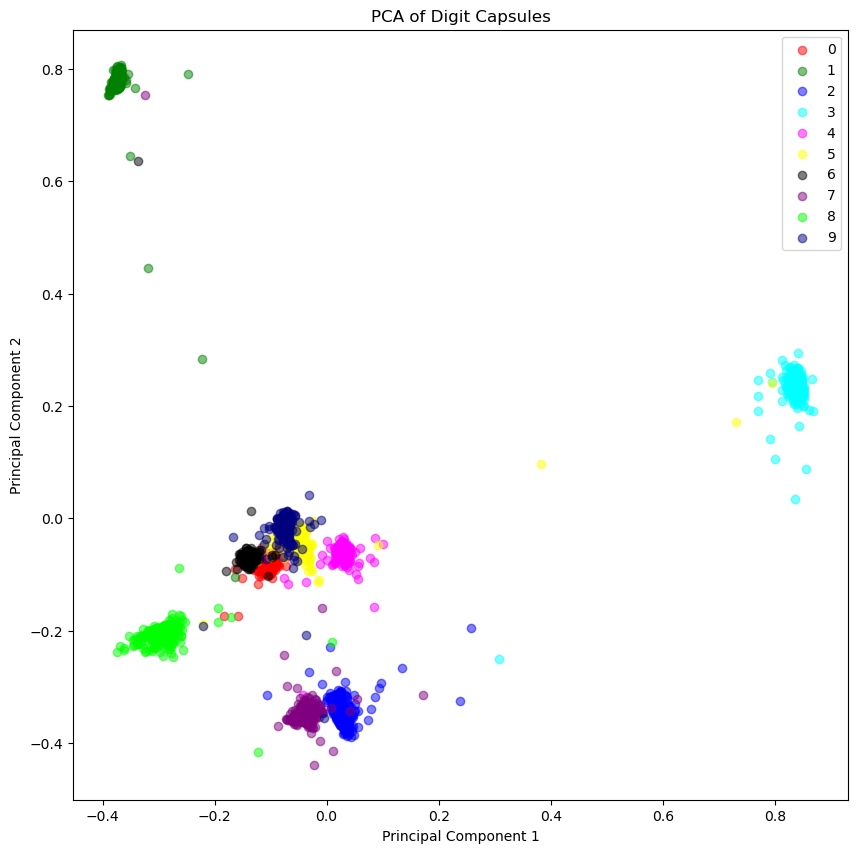

In [16]:
pca = PCA(n_components=2)
y_test_labels = np.argmax(y_test[:4000], axis=1)
pca_results = pca.fit_transform(digit_capsules_reshaped)

plt.figure(figsize=(10, 10))
for i, c in zip(range(10), ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'lime', 'navy']):
    mask = y_test_labels == i
    selected_pca_results = pca_results[mask]
    plt.scatter(selected_pca_results[:, 0], 
                selected_pca_results[:, 1], 
                c=c, label=str(i),alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of Digit Capsules')
plt.show()

In [17]:
test_file = pd.read_csv('../input/digit-recognizer/test.csv')
test_x = test_file.values
test_x = np.array(test_x)

test_x = test_x.astype('float32') / 255.
test_x = test_x.reshape(-1, 28, 28, 1)

op = eval_model.predict(test_x)

predictions = [np.argmax(i) for i in op[0]]

# Submission
submission = pd.DataFrame({
    'ImageId': [i + 1 for i in range(len(predictions))],
    'Label': predictions
})
submission.to_csv('submission.csv', index=False)

875/875 [==============================] - 12s 14ms/step
